<a href="https://colab.research.google.com/github/benoitmialet/Statistical-and-data-analysis-using-R-/blob/main/lab_dl_solving_regression_problem_with_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving a regression problem (California Housing dataset) with Neural Networks using Pytorch


## importing required libraries

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset


from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

# Automatically use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Load California housing dataset in a pandas dataframe and observe data

In [4]:
# Load California housing dataset and take a random subset to save memory
data = fetch_california_housing(as_frame=True)
complete_df = data.frame
df = complete_df.sample(n=5000, random_state=42)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,0.47700
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,0.45800
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,5.00001
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,2.18600
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,2.78000


In [7]:
# Basic statistics
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.847548,28.738600,5.415052,1.096529,1424.906200,2.964383,35.585798,-119.521650,2.059028
std,1.890851,12.530478,2.651202,0.574002,1108.469563,1.642381,2.140865,2.006263,1.148958
min,0.499900,1.000000,0.846154,0.500000,8.000000,1.263566,32.540000,-124.250000,0.149990
25%,2.553225,18.000000,4.416071,1.004559,784.000000,2.433980,33.930000,-121.742500,1.193750
50%,3.511400,29.000000,5.224950,1.047038,1163.500000,2.822057,34.220000,-118.470000,1.795000
75%,4.696700,37.000000,6.040717,1.097200,1721.250000,3.290997,37.692500,-117.990000,2.641750
max,15.000100,52.000000,132.533333,34.066667,16122.000000,83.171429,41.860000,-114.580000,5.000010


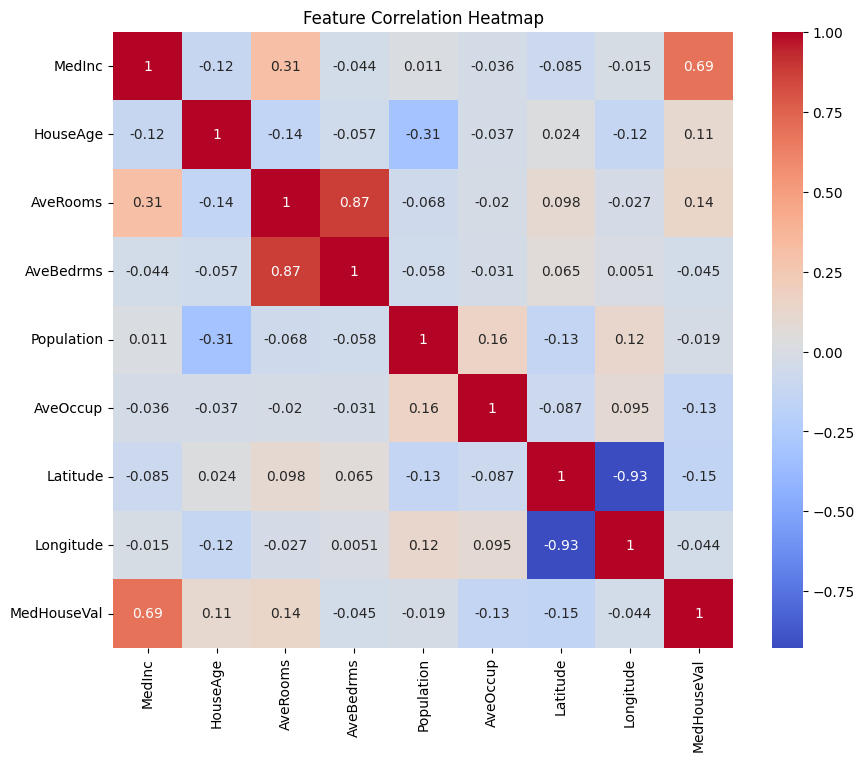

In [12]:
# Correlation heatmap with seaborn
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr() # built-in pandas function
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

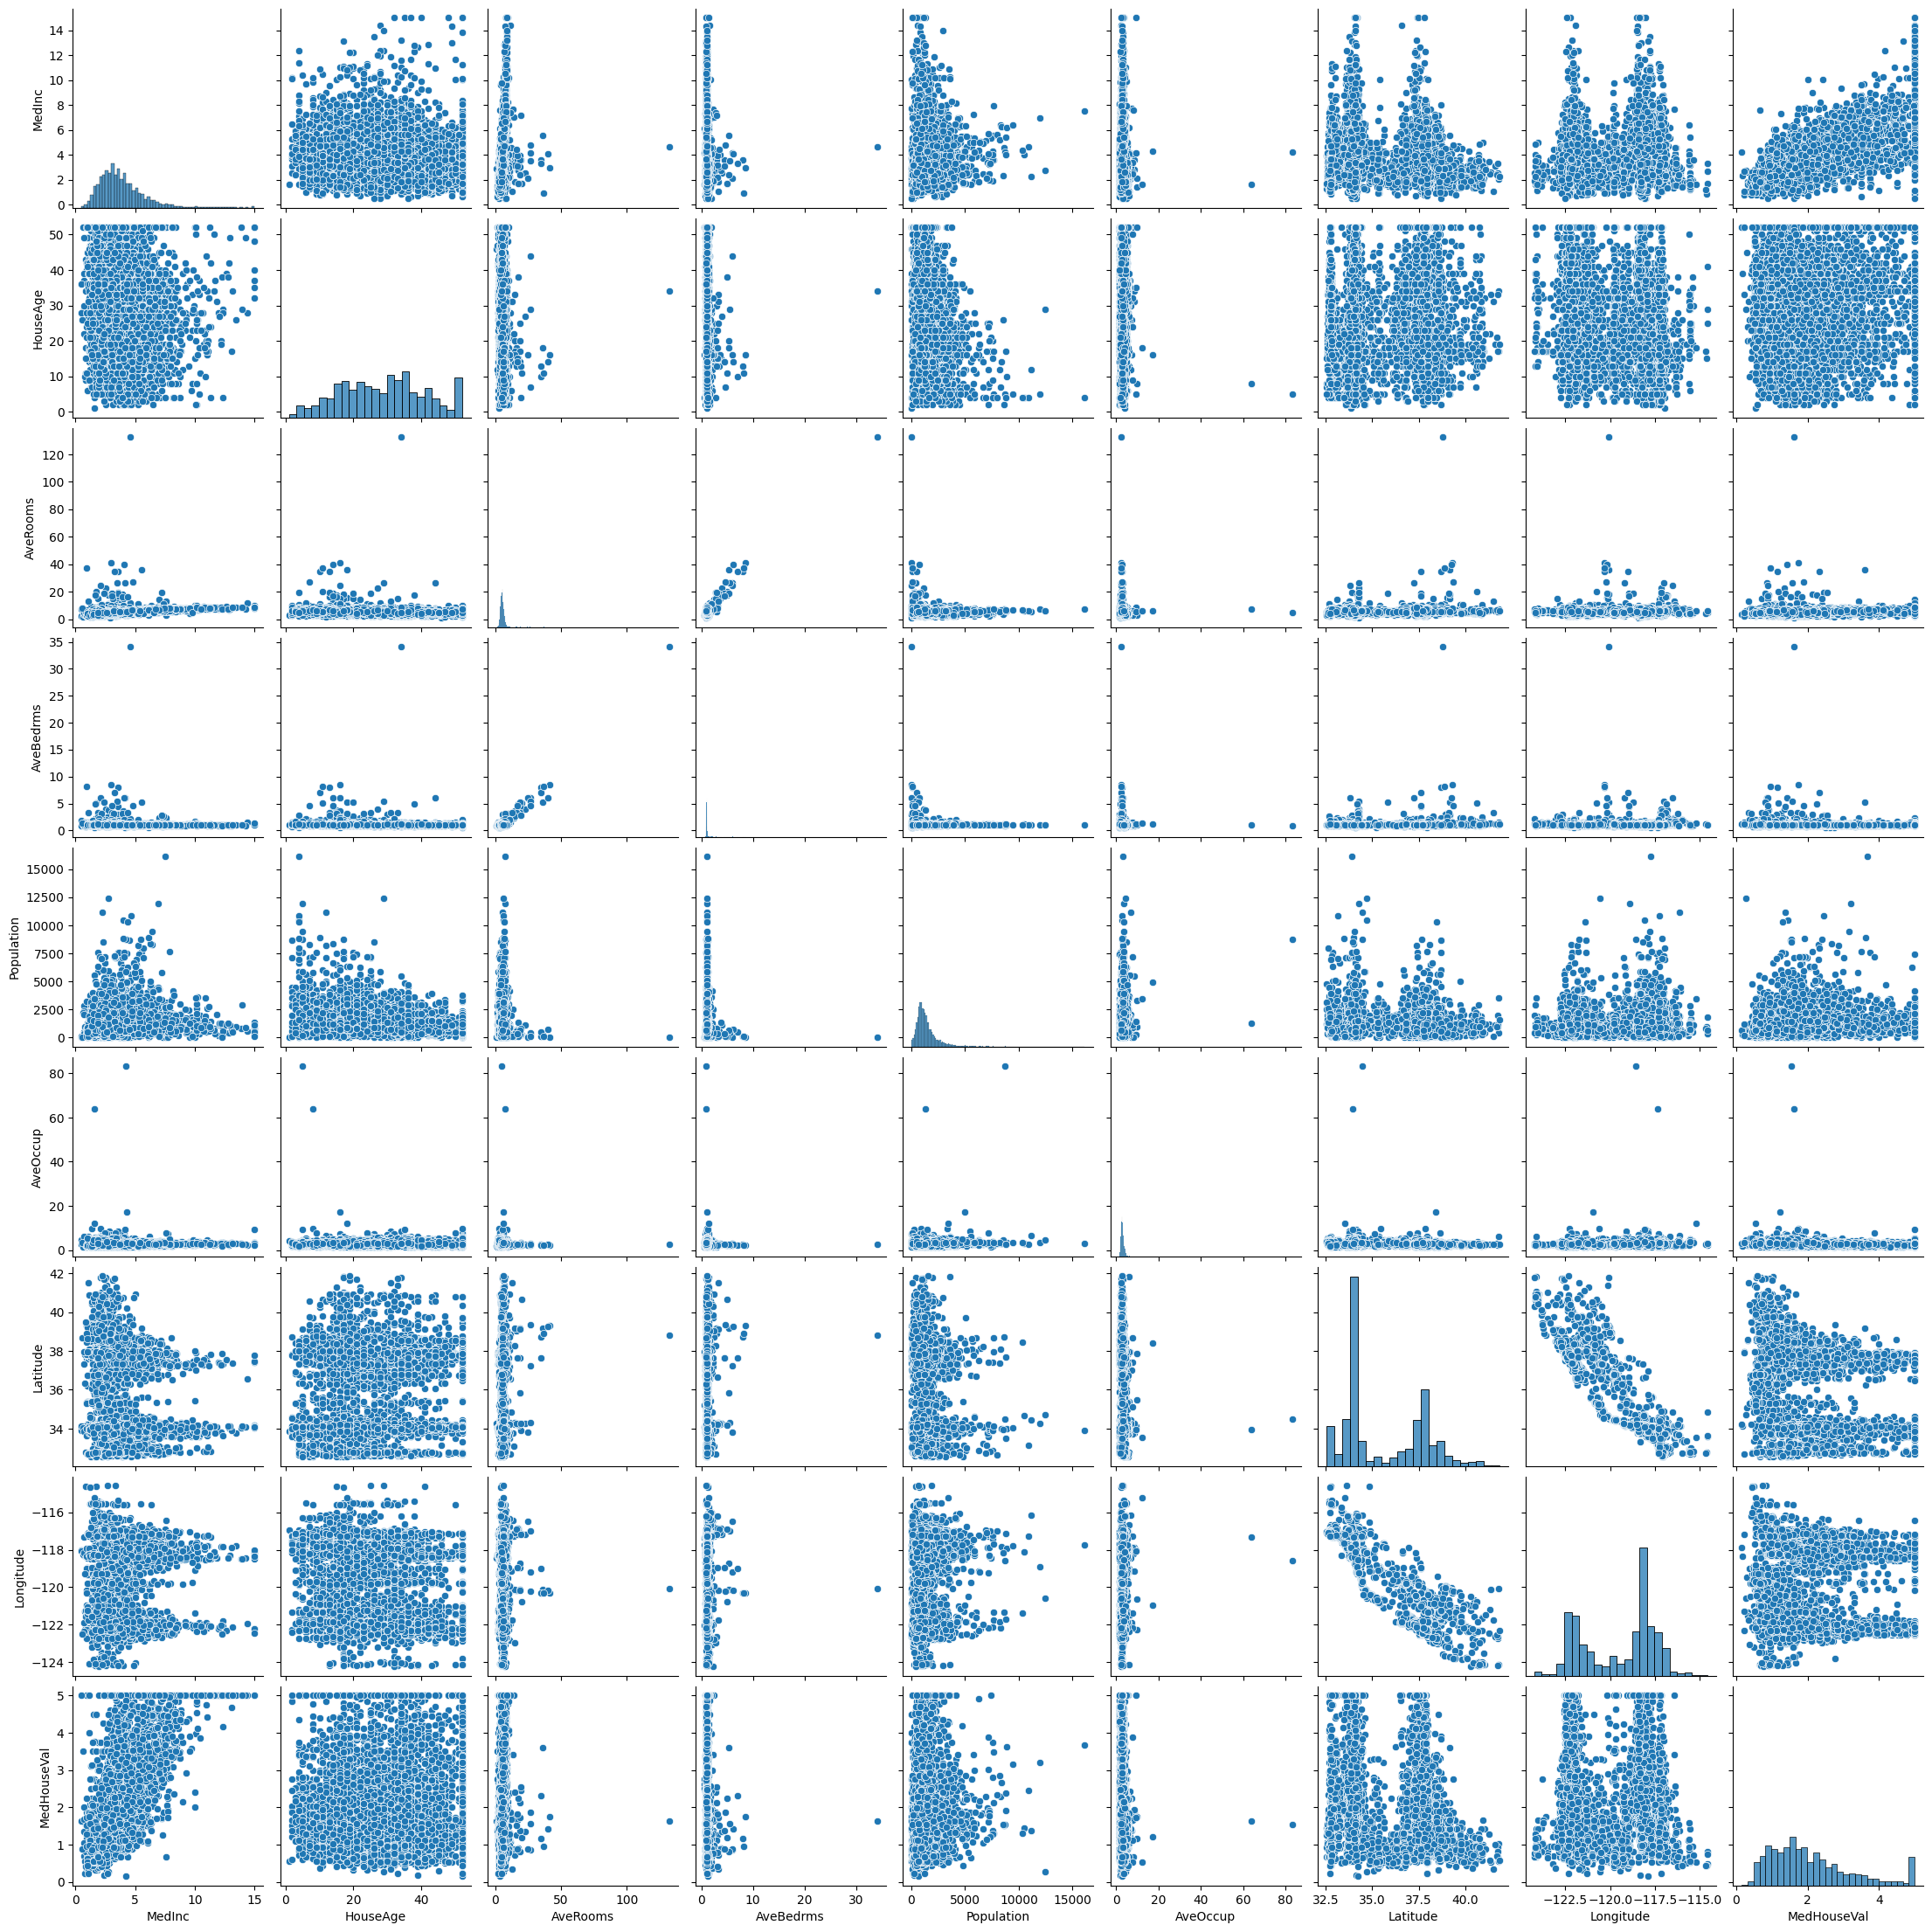

In [13]:
sns.pairplot(df)

## Prepare features and target for training

We first neet to extract data in a format that the model can handle. The objective is to obtain `X` as a numpy array of dimension [nb of samples, nb of features] and `y` as a numpy array of dimension [nb of samples]. We can do that with pandas.

In [5]:
# features = ['MedInc', 'AveRooms', 'HouseAge', 'AveOccup']
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup','Latitude', 'Longitude']
target = 'MedHouseVal'

X = df[features].values
y = df[target].values

In [26]:
print(X[:2])
print(type(X), X.shape)
print(y[:2])
print(type(y), y.shape)

[[ 1.68120000e+00  2.50000000e+01  4.19220056e+00  1.02228412e+00
   1.39200000e+03  3.87743733e+00  3.60600000e+01 -1.19010000e+02]
 [ 2.53130000e+00  3.00000000e+01  5.03938356e+00  1.19349315e+00
   1.56500000e+03  2.67979452e+00  3.51400000e+01 -1.19460000e+02]]
<class 'numpy.ndarray'> (5000, 8)
[0.477 0.458]
<class 'numpy.ndarray'> (5000,)


Then we need to split our data into train and test data. We will use the `train_test_split` function from the `sklearn.model_selection` module to split the dataset. Let's take 20% of the dataset as test set, and the remaining 80% for the training set. Let's also fix a random seed to ensure that the split is the same every time the code is run. This is useful for reproducibility.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=101
)

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 8)
(4000,)
(1000, 8)
(1000,)


Next step will be to rescale our data so that all feature will have the same scale (0 to 1). For that we can use `MinMaxScaler` function from `sklearn.preprocessing` module. We first instanciate the scaler, fit it, and then escale data with the fit scaler.

In [7]:
from sklearn.preprocessing import MinMaxScaler
# help(MinMaxScaler)

scaler = MinMaxScaler()
scaler.fit(X_train)


MinMaxScaler()

In [8]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.min())
print(X_train.max())

0.0
1.0


Last thing before training is to have data into Pytorch (`torch.tensor`) format so that we can process it with the model. We will just cast `torch.tensor()` method on each data split.
Pytorch also needs the target tensor to have at least one dimension for each sample. We will have thus to use `unsqueeze()` method on each `y` tensors, to "add" 1 dimension.

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# also works with torch.tensor(...).view(-1, 1)

## Create Dataset & DataLoader

Now we will define 2 python classes for data processing:
* `Dataset` class for handling data (we will name it `HousingDataset`). This class generally has to be written.
* `Dataloader` class for passing the data into the model, by batches. This class is generally already built by Pytorch.

take this tutorial as an example to create these two classes: https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
`Dataset` class will be much simpler here (around 7 rows)

In [10]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Custom Dataset class
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.X = features
        self.y = targets

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = HousingDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# Note that TensorDataset is a high level class that can handle this in a "one liner", if dataset building is quite straightforward:
# help(TensorDataset)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Define the model

We have to build a last class before building the method to train the model. We use `torch.nn.Module` as a parent class to define our model class. Starting from [this tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html), build a model class, that we will name `RegressionModel`.

In [35]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)   # Regularization
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = RegressionModel()

In [61]:
# another way to write the same model class using Sequential function:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),     # Regularization
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.ff(x)

model = RegressionModel()

## Define loss and optimizer

Loss and Optimizer are the two last elemnts to include to the training loop. They have to be chose and instantiated apart of the loop.

Find Mean Squared Error implementation in Pytorch and instantiate it. Name it `criterion`.
Do the same with Adam optimizer (`criterion`) and fix an arbitrary learnig rate value (inferior to 0.001)


In [36]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005) # RMSprop could have also been used like any other one

## Training loop

Now we train the model. We define the training loop that updates the weights of our neural network, following these steps:
* We loop over many epochs (training cycles) to progressively improve the model. Let's say 100.
* For each batch in the training set:
  * We compute the predictions
  * We evaluate how far they are from the actual values using the loss function (`criterion`)
  * We perform backpropagation to compute gradients
  * We call the optimizer to update model parameters (`optimizer`)
* After each epoch, we:
  * Record the average training loss
  * Evaluate the model on the validation set (test set) without updating the weights
  * Record the validation loss to monitor overfitting.

We also make sure that all data and model computations happen on the appropriate device (CPU or GPU), and we use torch.no_grad() during evaluation to save memory and speed things up.

Let’s build the training method now.

In [37]:
# Training loop with validation loss
from tqdm import tqdm

model.to(device)

train_losses = []
val_losses = []
for epoch in tqdm(range(100)):
    model.train()
    epoch_train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch.to(device)
        y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor).item()
        val_losses.append(val_loss)


100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


finally, let's plot `train_losses` and `val_losses` values on a same graph to check if any overfitting is happening.

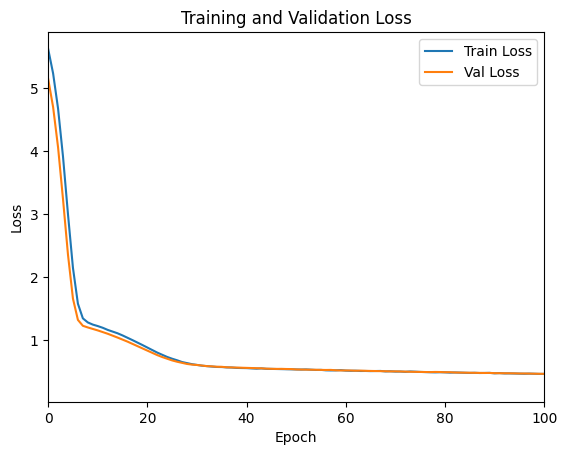

In [25]:
# Plot training and validation loss (plt.plot)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.legend()
plt.show()

No overfitting is detected, even if val curve is not decreasing much after ~50 epochs we should stop the training loop after 50-100 epochs, because the model is no more generalizing if we look closer a the val curve:

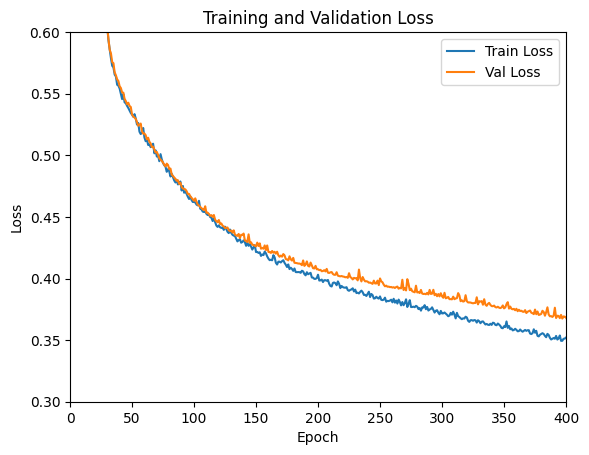

In [32]:
# Plot training and validation loss (after a 1000 epochs training)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0.3,0.6)
plt.xlim(0,400)

plt.legend()
plt.show()

## Evaluate the model on the test set

Now that training is complete, we evaluate the model's performance on data it has never seen before: the **test set**.

In a full machine learning workflow, we typically split the data into **three sets**:

- **Training set**: used to train the model.
- **Validation set**: used to tune hyperparameters and monitor performance during training.
- **Test set**: used only once at the end, to estimate how the model will perform on completely unseen data.

In our case, we only used a **training set** and a **test set**, and we didn’t tune any hyperparameters (like learning rate, number of layers, etc.). Therefore, it's acceptable here to use the **test set as both a validation and final evaluation set**.

However, if we were tuning hyperparameters or comparing different models, we would need to keep the test set strictly separate and introduce a third set (validation) to avoid overfitting to the test data.


We do the following:
- Switch the model to evaluation mode using `model.eval()`. This disables layers like dropout, ensuring consistent behavior during inference.
- Use `torch.no_grad()` to turn off gradient tracking since we don’t need to update weights during evaluation (this saves memory and speeds up computation).
- Predict house values for the test set.
- Compare predictions with the true values using standard regression metrics:
  - **MAE** (Mean Absolute Error): the average absolute difference between prediction and target. Easier to interpret than MSE.
  - **MSE** (Mean Squared Error): squares the errors before averaging, so it penalizes large errors more than small ones.
  - **RMSE** (Root Mean Squared Error): square root of MSE, gives error in the same unit as the target (e.g., in $100,000s).

In [38]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Compute metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
mae = mean_absolute_error(y_test_tensor, y_pred_tensor)
mse = mean_squared_error(y_test_tensor, y_pred_tensor)
rmse = root_mean_squared_error(y_test_tensor, y_pred_tensor)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 0.4916
Test MSE: 0.4737
Test RMSE: 0.6883


Finally, we visualize the predicted vs actual values. Ideally, points should lie close to the diagonal line, meaning the predictions are close to the ground truth.
Build a simple scatterplot with mtplotlib

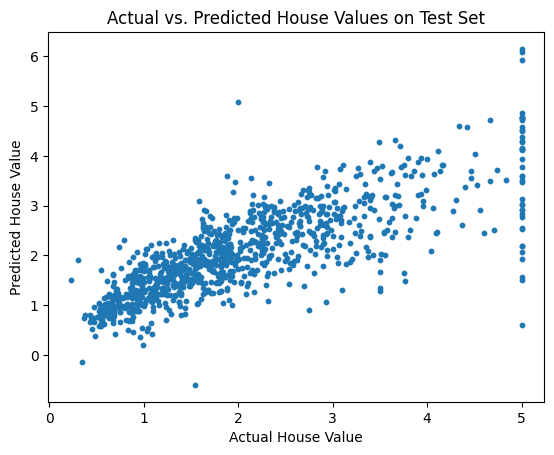

In [39]:
plt.scatter(y_test_tensor, y_pred_tensor, s=10) # s controls the size of the dots
plt.xlabel('Actual House Value')
plt.ylabel('Predicted House Value')
plt.title('Actual vs. Predicted House Values on Test Set')
plt.show()

In [60]:
# Save and load model
torch.save(model.state_dict(), 'sample_regression_model.pth')

# Load model example
loaded_model = RegressionModel()
loaded_model.load_state_dict(torch.load('sample_regression_model.pth'))

<All keys matched successfully>

## What could we do to go further:
* Add a feature selection study before (better but not fully required)
* log results to a tensorboard
* tune hyperparameters (learning rate...), for example by making a grid search function